# NLP_HW2 - Semantic Role Labeling 
Francesco Starna 1613660

**Setup**

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
torch.manual_seed(2020)

from collections import Counter
from typing import List
import json, csv, pickle

!pip install transformers
from transformers import BertTokenizer, BertModel, BertConfig

     |████████████████████████████████| 778kB 6.6MB/s 
     |████████████████████████████████| 890kB 16.5MB/s 
     |████████████████████████████████| 3.0MB 37.9MB/s 
     |████████████████████████████████| 1.1MB 36.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=487e7ae64eddf2afec94952c957ebfd2357909b24057954622a20bbbdb7aa9e8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/My Drive/AIRO/NLP/Homework/homework2/nlp2020-hw2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Preprocessing

### Vocabulary
The vocabulary class reads the json file and create the lemma, dependency,  postag, and role vocabularies. Save and load method are also provided.

In [3]:
class Vocab():

  def __init__(self, sizes, path=None, vocabs=None):
    self.lemma_vocab_size = sizes[0]
    self.dependency_vocab_size = sizes[1]
    self.postag_vocab_size = sizes[2]
    if path is not None: self.__build_vocabs(path)
    else:
      self.__lemma_vocab = vocabs['lemmas']
      self.__dependency_vocab = vocabs['dependencies']
      self.__postag_vocab = vocabs['postags']
      self.__predicate_vocab = vocabs['predicates']
      self.__role_vocab = vocabs['roles']

  def lemmas(self):
    return self.__lemma_vocab

  def dependencies(self):
    return self.__dependency_vocab

  def postags(self):
    return self.__postag_vocab

  def predicates(self):
    return self.__predicate_vocab

  def roles(self):
    return self.__role_vocab

  def save(self, path):
    with open(path, 'wb') as f:
      obj = {'vocab_sizes' : [self.lemma_vocab_size, self.dependency_vocab_size, self.postag_vocab_size],
             'lemmas': self.lemmas(),
             'dependencies': self.dependencies(),
             'postags': self.postags(),
             'predicates': self.predicates(),
             'roles': self.roles()}
      pickle.dump(obj, f)

  @staticmethod
  def load(path):
    with open(path, 'rb') as f:
      obj = pickle.load(f)
      return Vocab(sizes=obj['vocab_sizes'],
                   vocabs={'lemmas': obj['lemmas'], 
                           'dependencies': obj['dependencies'],
                           'postags': obj['postags'],
                           'predicates': obj['predicates'],
                           'roles': obj['roles']})
      
  def __build_vocabs(self, path):
    lemma_dict = Counter()
    postag_dict = Counter()
    role_dict = Counter()
    dependency_dict = Counter()
    predicate_dict = Counter()
    
    with open(path) as file:
      data = json.load(file)
      for elem in data.values():
        dependencies = elem['dependency_relations']
        for dep in dependencies:
          dependency_dict[dep] += 1
        
        lemmas = elem['lemmas']
        for lemma in lemmas:
          lemma_dict[lemma] += 1

        postags = elem['pos_tags']
        for pos in postags:
          postag_dict[pos] += 1
        
        predicates = elem['predicates']
        for pred in predicates:
          if pred != '_': predicate_dict[pred] += 1

        roles = elem['roles']
        for k in roles:
          role = [role for role in roles[k] if role != '_']
          role_dict.update(role)
    
    self.__dependency_vocab = {key:index for index, (key,_) in enumerate(dependency_dict.most_common(self.dependency_vocab_size-2))}
    self.__dependency_vocab['<unk>'] = self.dependency_vocab_size-2
    self.__dependency_vocab['<pad>'] = self.dependency_vocab_size-1

    self.__lemma_vocab = {key:index for index, (key,_) in enumerate(lemma_dict.most_common(self.lemma_vocab_size-2))}
    self.__lemma_vocab['<unk>'] = self.lemma_vocab_size-2
    self.__lemma_vocab['<pad>'] = self.lemma_vocab_size-1

    self.__postag_vocab = {key:index for index, (key,_) in enumerate(postag_dict.most_common(self.postag_vocab_size-2))}
    self.__postag_vocab['<unk>'] = self.postag_vocab_size-2
    self.__postag_vocab['<pad>'] = self.postag_vocab_size-1

    self.__predicate_vocab = {key:index for index,key in enumerate(predicate_dict)}
    self.__predicate_vocab['<empty>'] = len(self.__predicate_vocab)
    self.__predicate_vocab['<unk>'] = len(self.__predicate_vocab)
    self.__predicate_vocab['<pad>'] = len(self.__predicate_vocab)

    self.__role_vocab = {key:index for index,key in enumerate(role_dict)}
    self.__role_vocab['<empty>'] = len(self.__role_vocab)
    self.__role_vocab['<unk>'] = len(self.__role_vocab)
    self.__role_vocab['<pad>'] = len(self.__role_vocab)

In [ ]:
vocab = Vocab(path=folder+'data/train.json', sizes=[20000, 55, 40])

**Save/Load the Vocabulary**

In [ ]:
vocab.save(folder+'model/vocab.pickle')

In [4]:
vocab = Vocab.load(folder+'model/vocab.pickle')

### Embeddings

**Pretrained Embeddings**

Global Vectors from Standford Wikipedia 2014 + Gigaword 5 with 6B tokens and 100 vector size representation.

In [5]:
class GloVe():

  def __init__(self, path):
    self.__vectors = self.__load_vectors(path)
    self.vector_dim = len(next(iter(self.__vectors.values())))

  def __contains__(self, item):
    return item in self.__vectors

  def __getitem__(self, item):
    return self.__vectors[item] if item in self.__vectors else None
                   
  def __load_vectors(self, path):
    vectors_dict = dict()
    with open(path, 'r') as glove:
      for line in glove:
        values = line.split()
        word = values[0]
        vector = [float(i) for i in values[1:]]
        vectors_dict[word] = vector
    return vectors_dict

  def load_embeddings(self, v:Vocab):
    embeddings = torch.randn(len(v.lemmas()), self.vector_dim)
    for i, w in enumerate(v.lemmas()):
      if w in self: embeddings[i] = torch.FloatTensor(self[w])
    return embeddings

In [6]:
glove = GloVe(folder+"model/glove.6B.100d.txt")

**Contextualized Embeddings**

BERT tokenizer and pretrained models from [Transformers](https://huggingface.co/transformers/model_doc/bert.html) library

In [10]:
class BERT():
  def __init__(self, model_name, device):
    self.tokenizer = BertTokenizer.from_pretrained(model_name)
    bert_config = BertConfig.from_pretrained(model_name)
    self.model = BertModel.from_pretrained(model_name, config=bert_config)
    self.device = device
    self.bert_size = 768
    if device == 'cuda': self.model.cuda()

  #utility for replacing mistaken token from bert model
  @staticmethod 
  def replace_tokens(tokens):
    new_tokens = []
    for tok in tokens:
      if "`" in tok or "'" in tok:
        if tok == "'s": tok = "s"
        elif tok == "n't": tok = "not"
        else: tok = "'"
      else:
        if "." in tok and len(tok)>1: 
          if tok == '...': tok = tok.replace("...", ".")
          else: tok = tok.replace(".","")
        if "-" in tok and len(tok)>1:
          if len(tok)==2: tok = tok.replace("--","-")
          else: tok = tok.replace("-","")
        if "\\" in tok and len(tok)>1: 
          if "\\/" in tok: tok = tok.replace("\\/","")
          else: tok = "\\"
        if "," in tok and len(tok)>1: tok = tok.replace(",","")
        if "$" in tok and len(tok)>1: tok = tok.replace("$","")
        if "%" in tok and len(tok)>1: tok = tok.replace("%","")
        if "&" in tok and len(tok)>1: tok = tok.replace("&","")
        if "/" in tok and len(tok)>1: tok = tok.replace("/","")
        if ":" in tok and len(tok)>1: tok = tok[:tok.index(":")]
        if "*" in tok and len(tok)>1: tok = tok.replace("*","")
      new_tokens.append(tok)
    return new_tokens

  # generate ids, types and attention mask tensors for feed the BERT model
  def tokenize(self, sample, max_length=0):
    if max_length != 0:
      return self.tokenizer(sample, is_pretokenized=True, truncation=True, return_tensors="pt", padding='max_length', max_length=max_length)
    else:
      return self.tokenizer(sample, is_pretokenized=True, return_tensors="pt")

  # merge the BERT tokens and return representation vector
  def __select_vector(self, bert, tokens):
    output = []
    for token, vector in zip(tokens, bert):
      # selector first
      if not token.startswith(('##')):
        output.append(vector)
    return torch.tensor(np.array(output), device=self.device)

  # forward method of pretrained BERT model. It returns a tensor of shape (subwords, 768)
  def embedding(self, sample, pad=None):
    encoding = self.tokenize(sample)
    tokens = self.tokenizer.tokenize(' '.join(sample))
    with torch.no_grad():
      output = self.model.forward(input_ids=encoding['input_ids'].to(self.device),
                                  token_type_ids=encoding['token_type_ids'].to(self.device),
                                  attention_mask=encoding['attention_mask'].to(self.device))[0].squeeze(0)
    # remove CLS and SEP tokens
    embedding = self.__select_vector(output[1:-1,:].cpu().numpy(), tokens)
    if pad is None: return embedding
    else: return torch.cat([embedding, torch.zeros((pad,self.bert_size), device=self.device)], dim=0)

bert = BERT('bert-base-cased', 'cuda' if torch.cuda.is_available() else 'cpu')

### Encoder
The Encoder class takes care of encoding samples in PyTorch Tensors for feed the neural network. It also has a method decode output prediction.

In [7]:
class Encoder():

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  dep_attn_list = ['SBJ', 'OBJ', 'ADV', 'TMP', 'PMOD', 'LOC', 'OPRD', 'DIR', 'MNR', 'ROOT', 'PRP', 'LGS', 'NMOD', 'PRD', 'EXT', 'SUB', 'DEP', 'CONJ', 'APPO', 'AMOD', 'VC', 'COORD', 'DTV', 'PRT', 'PUT', 'PRN', 'EXTR', 'GAP-OBJ', 'GAP-SBJ', 'DEP-GAP']
  pos_attn_list = ['NN', 'IN', 'NNS', 'NNP', 'PRP', 'RB', 'TO', 'MD', 'VBD', 'VBZ', 'VBG', 'VBP', 'DT', 'JJ', '$', 'CD', 'CC', 'NNPS', 'VBN', 'VB', 'RBR', 'RP', 'JJR', 'WRB', ',', 'RBS', 'PRP$', 'WP', 'JJS', 'UH']

  # 1-hot encoding
  @staticmethod
  def __obj_2_index(obj, v:Vocab, case):
    if case is 'lem':
      return v.lemmas()[obj] if obj in v.lemmas() else v.lemmas()['<unk>']
    elif case is 'dep':
      return v.dependencies()[obj] if obj in v.dependencies() else v.dependencies()['<unk>']
    elif case is 'pos':
      return v.postags()[obj] if obj in v.postags() else v.postags()['<unk>']
    elif case is 'pre':
      return v.predicates()[obj] if obj in v.predicates() else v.predicates()['<unk>']
    elif case is 'rol':
      return v.roles()[obj] if obj in v.roles() else v.roles()['<unk>']

  # utility method for creating attention mask
  @staticmethod
  def __attention_mask(dep, pad):
    attn = []
    s_length = len(dep)
    for i in range(s_length):
      a = []
      for j in range(s_length):
        if dep[i] == 'ROOT' and dep[j] in Encoder.dep_attn_list or dep[j] in Encoder.pos_attn_list: a.append(0)
        else: a.append(1)
      attn.append(a+[1]*pad)
    for i in range(pad):
      attn.append([1]*(s_length+pad))
    return attn

  # utility method for model vocabulary embeddings
  @staticmethod
  def load_embeddings(v:Vocab, case):
    if case is 'dep':
      embeddings = torch.zeros(len(v.dependencies()), len(v.dependencies()))
      for i, obj in enumerate(v.dependencies()):
        embeddings[i][v.dependencies()[obj]] = 1
      return embeddings
    elif case is 'pos':
      embeddings = torch.zeros(len(v.postags()), len(v.postags()))
      for i, obj in enumerate(v.postags()):
        embeddings[i][v.postags()[obj]] = 1
      return embeddings
    elif case is 'pre':
      embeddings = torch.zeros(len(v.predicates()), len(v.predicates()))
      for i, obj in enumerate(v.predicates()):
        embeddings[i][v.predicates()[obj]] = 1
      return embeddings

  @staticmethod
  def encode(sample, v:Vocab, max_length=0, multioutput=False):
    
    if multioutput: return Encoder.multi_encode(sample, v, max_length)
    
    s_length = len(sample['lemmas'])
    if max_length == 0: max_length = s_length
    
    # inputs
    encoded_lemmas = [Encoder.__obj_2_index(l, v, 'lem') for l in sample['lemmas']]+[Encoder.__obj_2_index('<pad>', v, 'lem')]*(max_length-s_length)
    encoded_lemmas = torch.tensor(encoded_lemmas, device=Encoder.device)

    encoded_dependencies = [Encoder.__obj_2_index(d, v, 'dep') for d in sample['dependencies']]+[Encoder.__obj_2_index('<pad>', v, 'dep')]*(max_length-s_length)
    encoded_dependencies = torch.tensor(encoded_dependencies, device=Encoder.device)

    encoded_heads = sample['heads']+[999]*(max_length-s_length)
    encoded_heads = torch.FloatTensor(encoded_heads).to(Encoder.device)

    encoded_postags = [Encoder.__obj_2_index(p, v, 'pos') for p in sample['postags']]+[Encoder.__obj_2_index('<pad>', v, 'pos')]*(max_length-s_length)
    encoded_postags = torch.tensor(encoded_postags, device=Encoder.device)

    index, pred = sample['predicate'][0], sample['predicate'][1]
    encoded_predicate = [Encoder.__obj_2_index('<empty>', v, 'pre')]*max_length
    encoded_predicate[index] = Encoder.__obj_2_index(pred, v, 'pre')
    encoded_predicate = torch.tensor(encoded_predicate, device=Encoder.device)

    # bert
    encoded_bert = bert.embedding(BERT.replace_tokens(sample['words']), pad=max_length-s_length)
    if int(encoded_bert.shape[0]) != max_length: encoded_bert = encoded_bert[:max_length,:]

    # masks
    #pad_mask = torch.cat([torch.zeros((s_length)), torch.ones((max_length-s_length))], dim=-1).bool().to(Encoder.device)
    #attn_mask = Encoder.__attention_mask(sample['dependencies'], pad=max_length-s_length)
    #attn_mask = torch.tensor(attn_mask, dtype=torch.bool).to(Encoder.device)

    # target
    encoded_roles = [Encoder.__obj_2_index('<empty>', v, 'rol')]*s_length+[Encoder.__obj_2_index('<pad>', v, 'rol')]*(max_length-s_length)
    for index, role in sample['roles'].items():
      encoded_roles[int(index)] = Encoder.__obj_2_index(role, v, 'rol')
    encoded_roles = torch.LongTensor(encoded_roles).to(device=Encoder.device)
    
    encoded_inputs = {'lemma': encoded_lemmas,
                      #'bert': encoded_bert,
                      'dependency': encoded_dependencies,
                      'heads': encoded_heads,
                      'postag': encoded_postags,
                      'predicate': encoded_predicate}
                      #'pad_mask': pad_mask,
                      #'attn_mask': attn_mask}
     
    return {'inputs' : encoded_inputs,'targets' : encoded_roles}

  @staticmethod
  def multi_encode(sample, v:Vocab, max_length=0):
    encodings = Encoder.encode(sample, v, max_length)
    s_length = len(sample['lemmas'])
    if max_length == 0: max_length = s_length
    index, pred = sample['predicate'][0], sample['predicate'][1]
    encoded_pos = [0]*max_length
    encoded_pos[index] = 1
    encoded_pos = torch.FloatTensor(encoded_pos).to(Encoder.device) 
    encodings['inputs']['predicate_pos'] = encoded_pos
    encodings['targets'] = {'roles': encodings['targets'],
                            'predicates': encodings['inputs']['predicate']}
    del encodings['inputs']['predicate']
    return encodings

  # Decoding prediction
  @staticmethod
  def decode(predictions, v:Vocab, case):
    predictions = predictions.view(-1).tolist()
    if case == 'roles':
      inv = {val:k for k,val in v.roles().items()}
      predictions = [inv[p] for p in predictions]
    elif case == 'predicates':
      inv = {val:k for k,val in v.predicates().items()}
      predictions = [inv[p] for p in predictions]
    return predictions

### Dataset
The class organizes input json file and samples it using a dictionary

```
{'lemmas': lemmas, 'dependencies':'dependency relations', 'postags':'lemma tags', 'predicate': (position,predicate name'), 'roles': {position:target semantic role}}
```

In [8]:
class MyDataset(Dataset):

  def __init__(self, path, vocab, pad=False, truncate=False, multioutput=False):
    self.max_len = 0
    self.__vocab = vocab
    self.__pad = pad
    self.__truncate = truncate
    self.__multioutput = multioutput
    self.__data = self.__build_data(path)

  def __len__(self):
    return len(self.__data) if self.__truncate is False else self.__truncate

  def __getitem__(self, index):
    if not self.__multioutput:
      return Encoder.encode(self.__data[index], self.__vocab, self.max_len if self.__pad else 0) 
    else: return Encoder.multi_encode(self.__data[index], self.__vocab, self.max_len if self.__pad else 0)

  def get(self, i):
    return self.__data[i]

  def __build_data(self, path):
    data = list()
    max_len = 0
    with open(path) as file:
      json_data = json.load(file)
      for elem in json_data.values():
        sample = dict()
        sample['words'] = elem['words']
        sample['lemmas'] = elem['lemmas']
        sample['dependencies'] = elem['dependency_relations']
        sample['heads'] = [int(num) for num in elem['dependency_heads']]
        sample['postags'] = elem['pos_tags']
        for index, roles in elem['roles'].items():
          sample = sample.copy()
          sample['predicate'] = (int(index), elem['predicates'][int(index)])
          sample['roles'] = {i:r for i,r in enumerate(roles) if r != '_'}
          data.append(sample)
        
        if len(elem['words']) > self.max_len: self.max_len = len(elem['words'])
    return data

In [9]:
train_set = MyDataset(folder+'data/train.json', vocab, pad=True, multioutput=True)
dev_set = MyDataset(folder+'data/dev.json', vocab, pad=True, multioutput=True)
test_set = MyDataset(folder+'data/test.json', vocab, multioutput=True)

**Role dependencies and postags analysis**

In [ ]:
dep = Counter()
pos = Counter()
for i in range(len(train_set)):
  sample = train_set.get(i)
  roles = sample['roles'].keys()
  for index in roles:
    dep[sample['dependencies'][index]] +=1
    pos[sample['postags'][index]] +=1

dep_attn_list = [x[0] for x in dep.most_common(25)]
pos_attn_list = [x[0] for x in pos.most_common(25)]
print(dep_attn_list)
print(pos_attn_list)

['SBJ', 'OBJ', 'ADV', 'TMP', 'PMOD', 'LOC', 'OPRD', 'DIR', 'MNR', 'ROOT', 'PRP', 'LGS', 'NMOD', 'PRD', 'EXT', 'SUB', 'DEP', 'CONJ', 'APPO', 'AMOD', 'VC', 'COORD', 'DTV', 'PRT', 'PUT']
['NN', 'IN', 'NNS', 'NNP', 'PRP', 'RB', 'TO', 'MD', 'VBD', 'VBZ', 'VBG', 'VBP', 'DT', 'JJ', '$', 'CD', 'CC', 'NNPS', 'VBN', 'VB', 'RBR', 'RP', 'JJR', 'WRB', ',']



##Models


### Simple Model
Bidirectional LSTM with embeddings for argument identification and classification

In [10]:
class SimpleModel(nn.Module):

  def __init__(self, hparams):
    super(SimpleModel, self).__init__()

    # Glove Embeddings 
    self.lemma_embedding = nn.Embedding(hparams.lemma_vocab_size, hparams.lemma_embedding_dim)
    self.lemma_embedding.weight.data.copy_(hparams.glove_weights)
    
    # 1-hot Embeddings
    self.dependency_embedding = nn.Embedding(hparams.dependency_size, hparams.dependency_size)
    self.dependency_embedding.weight.data.copy_(hparams.dependency_weights)

    self.postag_embedding = nn.Embedding(hparams.postag_size, hparams.postag_size)
    self.postag_embedding.weight.data.copy_(hparams.postag_weights)

    self.predicate_embedding = nn.Embedding(hparams.predicate_size, hparams.predicate_size)
    self.predicate_embedding.weight.data.copy_(hparams.predicate_weights)

    # Bidirectional LSTM 
    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, num_layers=hparams.num_layers,
                        bidirectional=True, batch_first=True,
                        dropout = hparams.dropout if hparams.num_layers > 1 else 0)
    
    # dropout
    self.dropout = nn.Dropout(hparams.dropout)
    
    # linear classifier
    self.classifier = nn.Linear(hparams.hidden_dim*2, hparams.num_classes)

  def forward(self, x):
    lemma = self.lemma_embedding(x['lemma'])
    dependency = self.dependency_embedding(x['dependency'])
    heads = x['heads'].unsqueeze(2)
    postag = self.postag_embedding(x['postag'])
    predicate = self.predicate_embedding(x['predicate'])
    # concatenate embeddings
    x = torch.cat([lemma, dependency, heads, postag, predicate], dim=-1)
    o, (_, _) = self.lstm(x)
    o = self.dropout(o)
    output = self.classifier(o)
    return output

### BERT Model
Bidirectional LSTM with BERT embeddings for argument identification and classification

In [75]:
class BERTModel(nn.Module):

  def __init__(self, hparams):
    super(BERTModel, self).__init__()

    if (hparams.glove):
      # Glove Embeddings
      self.lemma_embedding = nn.Embedding(hparams.lemma_vocab_size, hparams.lemma_embedding_dim)
      self.lemma_embedding.weight.data.copy_(hparams.glove_weights)

    # 1-hot Embeddings
    self.dependency_embedding = nn.Embedding(hparams.dependency_size, hparams.dependency_size)
    self.dependency_embedding.weight.data.copy_(hparams.dependency_weights)

    self.postag_embedding = nn.Embedding(hparams.postag_size, hparams.postag_size)
    self.postag_embedding.weight.data.copy_(hparams.postag_weights)

    self.predicate_embedding = nn.Embedding(hparams.predicate_size, hparams.predicate_size)
    self.predicate_embedding.weight.data.copy_(hparams.predicate_weights)

    # Argument Bidirectional LSTM 
    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, num_layers=hparams.num_layers,
                        bidirectional=True, batch_first=True,
                        dropout = hparams.dropout if hparams.num_layers > 1 else 0)
    
    # dropout 
    self.dropout = nn.Dropout(hparams.dropout)
    
    # linear classifier
    self.classifier = nn.Linear(hparams.hidden_dim*2, hparams.num_classes)

  def forward(self, x):
    lemma = self.lemma_embedding(x['lemma'])
    dependency = self.dependency_embedding(x['dependency'])
    heads = x['heads'].unsqueeze(2)
    postag = self.postag_embedding(x['postag'])
    predicate = self.predicate_embedding(x['predicate'])
    # concatenate embeddings
    v = torch.cat([x['bert'], lemma, dependency, heads, postag, predicate], dim=-1)
    # LSTM
    o, (_, _) = self.lstm(v)
    o = self.dropout(o)
    output = self.classifier(o)
    return output

### Attention Model
MultiHead self attention model for argument identification and classification

In [10]:
#code inspired by https://pytorch.org/tutorials/beginner/transformer_tutorial.html
import math

class PositionalEncoding(nn.Module):

  def __init__(self, device, dropout=0.1):
    super(PositionalEncoding, self).__init__()
    
    self.dropout = nn.Dropout(p=dropout)
    self.device = device

  def forward(self, x):
    pe = torch.zeros(x.size(1), x.size(2), device=self.device)
    position = torch.arange(0, x.size(1), dtype=torch.float, device=self.device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, x.size(2), 2).float() * (-math.log(10000.0) / x.size(2))).to(self.device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    x = x + pe[:x.size(0), :]
    return self.dropout(x)

In [69]:
class AttentionModel(nn.Module):

  def __init__(self, hparams):
    super(AttentionModel, self).__init__()

    if (hparams.glove):
      # Glove Embeddings
      self.lemma_embedding = nn.Embedding(hparams.lemma_vocab_size, hparams.lemma_embedding_dim)
      self.lemma_embedding.weight.data.copy_(hparams.glove_weights)

    # 1-hot Embeddings
    self.dependency_embedding = nn.Embedding(hparams.dependency_size, hparams.dependency_size)
    self.dependency_embedding.weight.data.copy_(hparams.dependency_weights)

    self.postag_embedding = nn.Embedding(hparams.postag_size, hparams.postag_size)
    self.postag_embedding.weight.data.copy_(hparams.postag_weights)

    self.predicate_embedding = nn.Embedding(hparams.predicate_size, hparams.predicate_size)
    self.predicate_embedding.weight.data.copy_(hparams.predicate_weights)

    # additional pos encoding
    self.pos = PositionalEncoding(hparams.device)

    # convolutional layer
    self.conv = nn.Conv1d(hparams.embedding_dim, hparams.hidden_dim*2, kernel_size=5, padding=2)
    self.pool = nn.AvgPool1d(2)
    
    # Attention
    self.attention = nn.MultiheadAttention(hparams.hidden_dim, hparams.num_heads, dropout=hparams.dropout)
    self.num_heads = hparams.num_heads
    
    # Linear classifier
    self.classifier = nn.Linear(hparams.hidden_dim, hparams.num_classes)

  def forward(self, x):
    lemma = self.lemma_embedding(x['lemma'])
    dependency = self.dependency_embedding(x['dependency'])
    heads = x['heads'].unsqueeze(2)
    postag = self.postag_embedding(x['postag'])
    predicate = self.predicate_embedding(x['predicate'])
    # concatenate embeddings
    v = self.pos(torch.cat([lemma, dependency, heads, postag, predicate], dim=-1))
    # convolution
    c = self.conv(v.permute(0,2,1))
    q = self.pool(nn.functional.relu(c.permute(2,0,1)))
    # attention
    mask = (x['pad_mask'], torch.cat([x['attn_mask'] for i in range(self.num_heads)], dim=0))
    a, _ = self.attention(q, q, q, key_padding_mask=mask[0], attn_mask=mask[1])
    output = self.classifier(a.permute(1,0,2))
    return output

###Extra Model
Model for predicate disambiguation + argument identification and classification

In [11]:
class ExtraModel(nn.Module):

  def __init__(self, hparams):
    super(ExtraModel, self).__init__()

    if (hparams.glove):
      # Glove Embeddings
      self.lemma_embedding = nn.Embedding(hparams.lemma_vocab_size, hparams.lemma_embedding_dim)
      self.lemma_embedding.weight.data.copy_(hparams.glove_weights)

    # 1-hot Embeddings
    self.dependency_embedding = nn.Embedding(hparams.dependency_size, hparams.dependency_size)
    self.dependency_embedding.weight.data.copy_(hparams.dependency_weights)

    self.postag_embedding = nn.Embedding(hparams.postag_size, hparams.postag_size)
    self.postag_embedding.weight.data.copy_(hparams.postag_weights)

    # dropout
    self.dropout = nn.Dropout(hparams.dropout)

    # Argument Bidirectional LSTM 
    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, num_layers=hparams.num_layers,
                        bidirectional=True, batch_first=True,
                        dropout = hparams.dropout if hparams.num_layers > 1 else 0)
    
    # linear classifiers
    self.arg_classifier = nn.Linear(hparams.hidden_dim*2, hparams.num_classes)
    self.pred_classifier = nn.Linear(hparams.hidden_dim*2, hparams.num_predicates)


  def forward(self, x):
    lemma = self.lemma_embedding(x['lemma'])
    dependency = self.dependency_embedding(x['dependency'])
    heads = x['heads'].unsqueeze(2)
    predicate = x['predicate_pos'].unsqueeze(2)
    postag = self.postag_embedding(x['postag'])
    # concatenate embeddings
    v = torch.cat([lemma, dependency, heads, postag, predicate], dim=-1)
    # LSTM
    o, (_, _) = self.lstm(v)
    o = self.dropout(o)
    return self.arg_classifier(o), self.pred_classifier(o)

**Hyperparameters**

In [12]:
class HParams():

  def __init__(self, v:Vocab, g:GloVe=None):

    # lemma
    if (g is not None):
      self.lemma_vocab_size = v.lemma_vocab_size
      self.lemma_embedding_dim = g.vector_dim
      self.glove_weights = g.load_embeddings(v)
    self.glove = g is not None

    # dependency
    self.dependency_size = len(v.dependencies())
    self.head_size = 1
    self.dependency_weights = Encoder.load_embeddings(v, 'dep')

    # postag
    self.postag_size = len(v.postags())
    self.postag_weights = Encoder.load_embeddings(v, 'pos')

    # predicate
    self.predicate_size = len(v.predicates())
    self.predicate_weights = Encoder.load_embeddings(v, 'pre')

    # bert 
    self.bert_embedding_dim = 768
    
    # lstm
    self.embedding_dim = self.lemma_embedding_dim+self.dependency_size+self.postag_size+self.head_size+1#self.predicate_size
    self.num_layers = 2
    self.hidden_dim = 512

    # attention
    self.num_heads = 8

    # parameters
    self.dropout = 0.2
    self.device = Encoder.device
    self.num_classes = len(v.roles())-1
    self.num_predicates = len(v.predicates())-1

params = HParams(vocab, glove)

## Training

In [13]:
class Trainer():

  def __init__(self, model,loss_function, optimizer, multioutput=False):
    self.model = model
    self.multioutput = multioutput
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self, train_dataset, valid_dataset, epochs=1):
    
    train_loss = 0.0
    
    for epoch in range(epochs):
      print(' Epoch {:03d}'.format(epoch + 1))

      # train mode
      self.model.train()

      epoch_loss = 0.0

      for step, sample in enumerate(train_dataset):
        inputs = sample['inputs']
        targets = sample['targets']

        self.optimizer.zero_grad()

        if not self.multioutput:
          predictions = self.model(inputs)
          predictions = predictions.view(-1, predictions.shape[-1])
          loss = self.loss_function(predictions, targets.view(-1))
        else:
          predictions1, predictions2 = self.model(inputs)
          predictions1 = predictions1.view(-1, predictions1.shape[-1])
          predictions2 = predictions2.view(-1, predictions2.shape[-1])
          loss1 = self.loss_function[0](predictions1, targets['roles'].view(-1))
          loss2 = self.loss_function[1](predictions2, targets['predicates'].view(-1))
          loss = loss1+loss2
          
        loss.backward()

        self.optimizer.step()

        epoch_loss += loss.tolist()
      
      avg_epoch_loss = epoch_loss/len(train_dataset)
      train_loss += avg_epoch_loss
      print('\n\t[E: {:2d}] train loss = {:0.4f}'.format(epoch+1, avg_epoch_loss))

      valid_loss = self.evaluate(valid_dataset)
      print('\t[E: {:2d}] valid loss = {:0.4f}'.format(epoch+1, valid_loss))

    avg_epoch_loss = train_loss / epochs
    return valid_loss

  def evaluate(self, valid_dataset):
    valid_loss = 0.0
    
    # evaluation mode
    self.model.eval()

    with torch.no_grad():
      for sample in valid_dataset:

        inputs = sample['inputs']
        targets = sample['targets']
        
        if not self.multioutput:
          predictions = self.model(inputs)
          predictions = predictions.view(-1, predictions.shape[-1])
          loss = self.loss_function(predictions, targets.view(-1))
        else:
          predictions1, predictions2 = self.model(inputs)
          predictions1 = predictions1.view(-1, predictions1.shape[-1])
          predictions2 = predictions2.view(-1, predictions2.shape[-1])
          loss1 = self.loss_function[0](predictions1, targets['roles'].view(-1))
          loss2 = self.loss_function[1](predictions2, targets['predicates'].view(-1))
          loss = loss1+loss2
        
        valid_loss += loss.tolist()

    return valid_loss / len(valid_dataset)

  def predict(self, x):
    # evaluation mode
    self.model.eval()
    with torch.no_grad():
      inputs = x['inputs']
      inputs = {k:v.unsqueeze(0) for k,v in inputs.items() if type(v) is torch.Tensor}

      if not self.multioutput:
        logits = self.model(inputs)
        predictions = torch.argmax(logits, -1)
        return predictions
      else:
       logits1, logits2 = self.model(inputs)
       predictions1 = torch.argmax(logits1, -1)
       predictions2 = torch.argmax(logits2, -1)
       return predictions1, predictions2

In [14]:
model_name = 'extra'
#model = SimpleModel(params)
#model = BERTModel(params)
#model = AttentionModel(params)
model = ExtraModel(params)
if Encoder.device == 'cuda': model.cuda()

trainer = Trainer(
    model = model,
    #loss_function = nn.CrossEntropyLoss(ignore_index=vocab.roles()['<pad>']),
    loss_function = (nn.CrossEntropyLoss(ignore_index=vocab.roles()['<pad>']), 
                     nn.CrossEntropyLoss(ignore_index=vocab.predicates()['<pad>'])),
    optimizer = optim.Adam(model.parameters()),
    multioutput=True
)

In [15]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
valid_data = DataLoader(dev_set, batch_size=64)
test_data = DataLoader(test_set, batch_size=1)

In [ ]:
min_loss = 100
while(True):
  torch.save(model.state_dict(), folder+'model/'+model_name+'-model.txt')
  trainer.train(train_data, valid_data, epochs=1)
  valid_loss = trainer.evaluate(valid_data)
  if valid_loss < min_loss: min_loss = valid_loss
  else: break

**Save/Load model**

In [ ]:
torch.save(model.state_dict(), folder+'model/'+model_name+'-model.txt')

In [37]:
model.load_state_dict(torch.load(folder+'model/'+model_name+'-model.txt', map_location=torch.device(Encoder.device)))

<All keys matched successfully>

## Evaluation

### Loss

In [26]:
print("test set loss: {}".format(trainer.evaluate(test_data)))

test set loss: 0.07219687696495303


### Prediction

In [84]:
def predict(sample):
  encoded = Encoder.encode(sample, vocab)
  predictions = trainer.predict(encoded)
  predictions = Encoder.decode(predictions, vocab, 'roles')
  targets = Encoder.decode(encoded['targets'], vocab, 'roles')
  predictions = [p if p != '<empty>' else '-' for p in predictions]
  targets = [t if t != '<empty>' else '-' for t in targets]
  print('predictions\t{p}\ntargets\t\t{t}'.format(p=predictions, t=targets))

def multi_predict(sample):
  encoded = Encoder.multi_encode(sample, vocab)
  predictions1, predictions2 = trainer.predict(encoded)
  predictions1 = Encoder.decode(predictions1, vocab, 'roles')
  targets1 = Encoder.decode(encoded['targets']['roles'], vocab, 'roles')
  predictions1 = [p if p != '<empty>' else '-' for p in predictions1]
  targets1 = [t if t != '<empty>' else '-' for t in targets1]
  predictions2 = Encoder.decode(predictions2.view(-1), vocab, 'predicates')
  targets2 = Encoder.decode(encoded['targets']['predicates'], vocab, 'predicates')
  predictions2 = [p if p != '<empty>' else '-' for p in predictions2]
  targets2 = [t if t != '<empty>' else '-' for t in targets2]
  print('ROLES')
  print('predictions1\t{p}\ntargets1\t{t}'.format(p=predictions1, t=targets1))
  print('\nPREDICATE')
  print('predictions2\t{p}\ntargets2\t{t}'.format(p=predictions2, t=targets2))

In [85]:
#predict(test_set.get(4))
multi_predict(test_set.get(4))

ROLES
predictions1	['-', '-', '-', 'Theme', '-', '-', 'Time', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
targets1	['-', '-', '-', 'Theme', '-', '-', 'Time', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']

PREDICATE
predictions2	['-', '-', '-', '-', '-', 'STAY_DWELL', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
targets2	['-', '-', '-', '-', '-', 'STAY_DWELL', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


### Score

In [ ]:
pred_id, gold_id, identified = 0, 0, 0
roles = dict.fromkeys(vocab.roles(), 0)
del roles['<unk>']
del roles['<pad>']

#confusion matrix
matrix = dict()
for role in roles:
  matrix[role] = roles.copy()

#scores
precision = dict()
recall = dict()

for i in range(len(test_set)):
  encoded = Encoder.encode(test_set.get(i), vocab)
  predictions = trainer.predict(encoded)
  predictions = Encoder.decode(predictions.view(-1), vocab, 'roles')
  targets = Encoder.decode(encoded['targets'], vocab, 'roles')
  
  for pred, gold in zip(predictions, targets):
    matrix[gold][pred] += 1
    if gold != '<empty>':
      gold_id += 1
    if pred != '<empty>':
      pred_id += 1
    if gold != '<empty>' and pred != '<empty>':
      identified += 1

for label in matrix:
  gold = sum([matrix[label][k] for k in matrix])
  pred = sum([matrix[k][label] for k in matrix])
  precision[label] = matrix[label][label]/pred if pred != 0 and matrix[label][label] != 0 else 1
  recall[label] = matrix[label][label]/gold if gold != 0 and matrix[label][label] != 0 else 1

print('ARGUMENT IDENTIFICATION')
print('[PRECISION]\t[RECALL]\t[F1 SCORE]')
id_precision = identified/gold_id
id_recall = identified/pred_id
id_f1 = 2*id_precision*id_recall/(id_precision+id_recall)
print('{:0.2f}\t\t{:0.2f}\t\t{:0.2f}'.format(id_precision, id_recall, id_f1))

print('\n')
print('ARGUMENT CLASSIFICATION')
print('[ARGUMENT]\t[PRECISION]\t[RECALL]\t[F1 SCORE]')
precision_tot = 0
recall_tot = 0
for label in matrix:
  f1 = 2*precision[label]*recall[label]/(precision[label]+recall[label])
  precision_tot += precision[label]
  recall_tot += recall[label]
  print('{:10}\t{:0.2f}\t\t{:0.2f}\t\t{:0.2f}'.format(label, precision[label], recall[label], f1))

print('\n')
print('AVERAGE SCORE')
print('[PRECISION]\t[RECALL]\t[F1 SCORE]')
precision_tot /= (len(vocab.roles())-1)
recall_tot /= (len(vocab.roles())-1)
f1_tot = 2*precision_tot*recall_tot/(precision_tot+recall_tot)
print('{:0.2f}\t\t{:0.2f}\t\t{:0.2f}'.format(precision_tot, recall_tot, f1_tot))

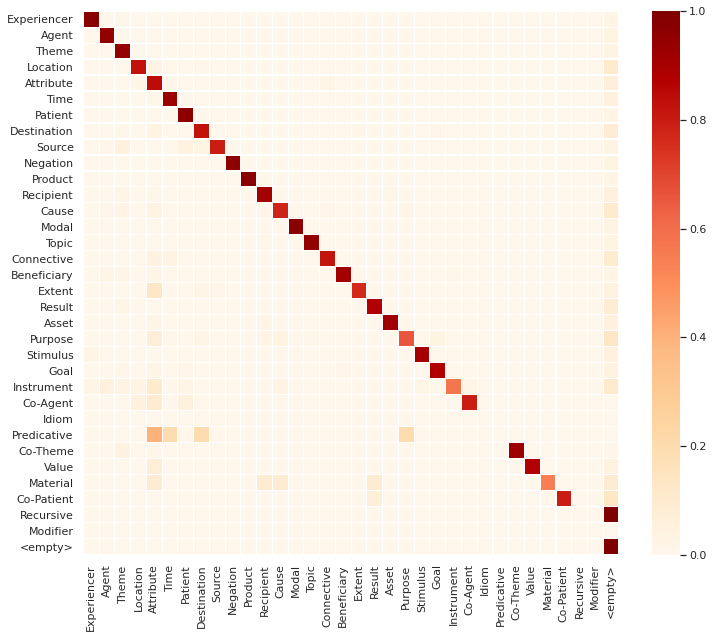

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

confusion = dict()
for key in matrix:
  num = sum(matrix[key].values())
  factor=1.0/num if num != 0 else 1.0
  n = {k:v*factor for (k,v) in matrix[key].items()}
  confusion[key] = n

labels = [label for label in matrix] 

data = [np.array(list(d.values())) for d in confusion.values()]
plt.figure(figsize=(12, 10))
ax = sns.heatmap(data, xticklabels=labels, yticklabels=labels, linewidths=.1, cmap='OrRd')

In [54]:
class Oncoder():

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  dep_attn_list = ['SBJ', 'OBJ', 'ADV', 'TMP', 'PMOD', 'LOC', 'OPRD', 'DIR', 'MNR', 'ROOT', 'PRP', 'LGS', 'NMOD', 'PRD', 'EXT', 'SUB', 'DEP', 'CONJ', 'APPO', 'AMOD', 'VC', 'COORD', 'DTV', 'PRT', 'PUT', 'PRN', 'EXTR', 'GAP-OBJ', 'GAP-SBJ', 'DEP-GAP']
  pos_attn_list = ['NN', 'IN', 'NNS', 'NNP', 'PRP', 'RB', 'TO', 'MD', 'VBD', 'VBZ', 'VBG', 'VBP', 'DT', 'JJ', '$', 'CD', 'CC', 'NNPS', 'VBN', 'VB', 'RBR', 'RP', 'JJR', 'WRB', ',', 'RBS', 'PRP$', 'WP', 'JJS', 'UH']

  # 1-hot encoding
  @staticmethod
  def __obj_2_index(obj, v:Vocab, case):
    if case is 'lem':
      return v.lemmas()[obj] if obj in v.lemmas() else v.lemmas()['<unk>']
    elif case is 'dep':
      return v.dependencies()[obj] if obj in v.dependencies() else v.dependencies()['<unk>']
    elif case is 'pos':
      return v.postags()[obj] if obj in v.postags() else v.postags()['<unk>']
    elif case is 'pre':
      return v.predicates()[obj] if obj in v.predicates() else v.predicates()['<unk>']
    elif case is 'rol':
      return v.roles()[obj] if obj in v.roles() else v.roles()['<unk>']

  # utility method for creating attention mask
  @staticmethod
  def __attention_mask(dep, pad):
    attn = []
    s_length = len(dep)
    for i in range(s_length):
      a = []
      for j in range(s_length):
        if dep[i] == 'ROOT' and dep[j] in Oncoder.dep_attn_list or dep[j] in Oncoder.pos_attn_list: a.append(0)
        else: a.append(1)
      attn.append(a+[1]*pad)
    for i in range(pad):
      attn.append([1]*(s_length+pad))
    return attn

  # utility method for model vocabulary embeddings
  @staticmethod
  def load_embeddings(v:Vocab, case):
    if case is 'dep':
      embeddings = torch.zeros(len(v.dependencies()), len(v.dependencies()))
      for i, obj in enumerate(v.dependencies()):
        embeddings[i][v.dependencies()[obj]] = 1
      return embeddings
    elif case is 'pos':
      embeddings = torch.zeros(len(v.postags()), len(v.postags()))
      for i, obj in enumerate(v.postags()):
        embeddings[i][v.postags()[obj]] = 1
      return embeddings
    elif case is 'pre':
      embeddings = torch.zeros(len(v.predicates()), len(v.predicates()))
      for i, obj in enumerate(v.predicates()):
        embeddings[i][v.predicates()[obj]] = 1
      return embeddings

  @staticmethod
  def encode(sample, v:Vocab, max_length=0, bert=None, test=False, multioutput=False):
    
    s_length = len(sample['lemmas'])
    if max_length == 0: max_length = s_length
    
    # inputs
    encoded_lemmas = [Oncoder.__obj_2_index(l, v, 'lem') for l in sample['lemmas']]+[Oncoder.__obj_2_index('<pad>', v, 'lem')]*(max_length-s_length)
    encoded_lemmas = torch.tensor(encoded_lemmas, device=Oncoder.device)

    encoded_dependencies = [Oncoder.__obj_2_index(d, v, 'dep') for d in sample['dependencies']]+[Oncoder.__obj_2_index('<pad>', v, 'dep')]*(max_length-s_length)
    encoded_dependencies = torch.tensor(encoded_dependencies, device=Oncoder.device)

    encoded_heads = sample['heads']+[999]*(max_length-s_length)
    encoded_heads = torch.FloatTensor(encoded_heads).to(Oncoder.device)

    encoded_postags = [Oncoder.__obj_2_index(p, v, 'pos') for p in sample['postags']]+[Oncoder.__obj_2_index('<pad>', v, 'pos')]*(max_length-s_length)
    encoded_postags = torch.tensor(encoded_postags, device=Oncoder.device)

    # masks
    #pad_mask = torch.cat([torch.zeros((s_length)), torch.ones((max_length-s_length))], dim=-1).bool().to(Encoder.device)
    #attn_mask = Encoder.__attention_mask(sample['dependencies'], pad=max_length-s_length)
    #attn_mask = torch.tensor(attn_mask, dtype=torch.bool).to(Encoder.device)
    
    encoded_inputs = {'lemma': encoded_lemmas,
                      'dependency': encoded_dependencies,
                      'heads': encoded_heads,
                      'postag': encoded_postags}
                      #'pad_mask': pad_mask,
                      #'attn_mask': attn_mask}
    
    if not multioutput:
      index, pred = sample['predicate'][0], sample['predicate'][1]
      encoded_predicate = [Oncoder.__obj_2_index('<empty>', v, 'pre')]*max_length
      encoded_predicate[index] = Oncoder.__obj_2_index(pred, v, 'pre')
      encoded_predicate = torch.tensor(encoded_predicate, device=Oncoder.device)
      encoded_inputs['predicate'] = encoded_predicate
      
    if bert is not None:
      # bert
      encoded_bert = bert.embedding(BERT.replace_tokens(sample['words']), pad=max_length-s_length)
      if int(encoded_bert.shape[0]) != max_length: encoded_bert = encoded_bert[:max_length,:]
      encoded_inputs['bert'] = encoded_bert
                      
    if not test:
      # target
      encoded_roles = [Oncoder.__obj_2_index('<empty>', v, 'rol')]*s_length+[Oncoder.__obj_2_index('<pad>', v, 'rol')]*(max_length-s_length)
      for index, role in sample['roles'].items():
        encoded_roles[int(index)] = Oncoder.__obj_2_index(role, v, 'rol')
      encoded_roles = torch.LongTensor(encoded_roles).to(device=Oncoder.device)
      return {'inputs' : encoded_inputs,'targets' : encoded_roles}
      
    else: return {'inputs' : encoded_inputs}

  @staticmethod
  def multi_encode(sample, v:Vocab, max_length=0, bert=None, test=False):
    encodings = Oncoder.encode(sample, v, max_length, bert, test, multioutput=True)
    s_length = len(sample['lemmas'])
    if max_length == 0: max_length = s_length
    index = sample['predicate']
    encoded_pos = [0]*max_length
    encoded_pos[index] = 1
    encoded_pos = torch.FloatTensor(encoded_pos).to(Oncoder.device) 
    encodings['inputs']['predicate_pos'] = encoded_pos
    
    if not test:
      encodings['targets'] = {'roles': encodings['targets'],
                              'predicates': encodings['inputs']['predicate']}
      del encodings['inputs']['predicate']
    return encodings

  @staticmethod
  def build_data(elem, multioutput=False):
    data = list()
    sample = dict()
    sample['words'] = elem['words']
    sample['lemmas'] = elem['lemmas']
    sample['dependencies'] = elem['dependency_relations']
    sample['heads'] = [int(num) for num in elem['dependency_heads']]
    sample['postags'] = elem['pos_tags']
    
    if not multioutput:
      predicates = {i:p for i,p in enumerate(elem['predicates']) if p != '_'}
      for index, pred in predicates.items():
        sample = sample.copy()
        sample['predicate'] = (index, pred)
        data.append(sample)
      return data
    
    else:
      predicates = [i for i,p in enumerate(elem['predicates']) if p != 0]
      for index in predicates:
        sample = sample.copy()
        sample['predicate'] = index
        data.append(sample)
      return data
          
  # Decoding prediction
  @staticmethod
  def decode(predictions, v:Vocab, case):
    predictions = predictions.view(-1).tolist()
    if case == 'roles':
      inv = {val:k for k,val in v.roles().items()}
      predictions = [inv[p] if p != v.roles()['<empty>'] else '_' for p in predictions]
      return predictions
    elif case == 'predicates':
      inv = {val:k for k,val in v.predicates().items()}
      predictions = [inv[p] if p != v.predicates()['<empty>'] else '_' for p in predictions]
      for p in predictions:
        if p != '_': return p

In [33]:
sentence = {
                        "words":
                            [  "In",  "any",  "event",  ",",  "Mr.",  "Englund",  "and",  "many",  "others",  "say",  "that",  "the",  "easy",  "gains",  "in",  "narrowing",  "the",  "trade",  "gap",  "have",  "already",  "been",  "made",  "."  ],
                        "lemmas":
                            ["in", "any", "event", ",", "mr.", "englund", "and", "many", "others", "say", "that", "the", "easy", "gain", "in", "narrow", "the", "trade", "gap", "have", "already", "be", "make",  "."],
                        "pos_tags":
                            ["IN", "DT", "NN", ",", "NNP", "NNP", "CC", "DT", "NNS", "VBP", "IN", "DT", "JJ", "NNS", "IN", "VBG", "DT", "NN", "NN", "VBP", "RB", "VBN", "VBN", "."],
                        "dependency_heads":
                            ["10", "3", "1", "10", "6", "10", "6", "9", "7", "0", "10", "14", "14", "20", "14", "15", "19", "19", "16", "11", "20", "20", "22", "10"],
                        "dependency_relations":
                            ["ADV", "NMOD", "PMOD", "P", "TITLE", "SBJ", "COORD", "NMOD", "CONJ", "ROOT", "OBJ", "NMOD", "NMOD", "SBJ", "NMOD", "PMOD", "NMOD", "NMOD", "OBJ", "SUB", "TMP", "VC", "VC", "P"],
                        "predicates":
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0 ],
                    }

In [55]:
roles = {}
predicates = ['_']*len(sentence['words'])
samples = Oncoder.build_data(sentence, multioutput=True)

for sample in samples:
  encoded = Oncoder.multi_encode(sample, vocab, bert=None, test=True)
  predicted_roles, predicted_predicates = trainer.predict(encoded)
  roles[sample['predicate']] = Oncoder.decode(predicted_roles, vocab, 'roles')
  predicates[sample['predicate']] = Oncoder.decode(predicted_predicates, vocab, 'predicates')

print(roles)
print(predicates)

{9: ['Connective', '_', '_', '_', '_', 'Agent', '_', '_', '_', '_', 'Theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 15: ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'Patient', '_', '_', '_', '_', '_'], 22: ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'Patient', '_', '_', '_', '_', '_', '_', 'Time', '_', '_', '_']}
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'AFFIRM', '_', '_', '_', '_', '_', 'REDUCE_DIMINISH', '_', '_', '_', '_', '_', '_', 'INCITE_INDUCE', '_']
